In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

In [2]:
files_grabbed = []
files_info = []
path_check_include = ''

path_ign = os.getcwd() + '/data'
files_grabbed = glob.glob(os.path.join(path_ign, '*.jp2'))
files_info = glob.glob(os.path.join(path_ign, '*.tab'))
files_grabbed = [x for x in files_grabbed if path_check_include in x]
files_info = [x for x in files_info if path_check_include in x]

print("- nombre d'images:", len(files_grabbed), ', nb files info coord:', len(files_info))

- nombre d'images: 191 , nb files info coord: 191


In [3]:
def read_one(fname):
    img = cv2.imread(fname)      
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    return img
fname = files_grabbed[0]
full_img = read_one(fname)

In [4]:
NB_SPLIT = 16

def split_image(img, nb_split):
    img_split = []
    h, w, c = img.shape
    for i in range(nb_split):
        for j in range(nb_split):
            img_split.append(img[i*h//nb_split:(i+1)*h//nb_split, j*w//nb_split:(j+1)*w//nb_split, :])
    return img_split

img_split = split_image(full_img, NB_SPLIT)
img = img_split[0]

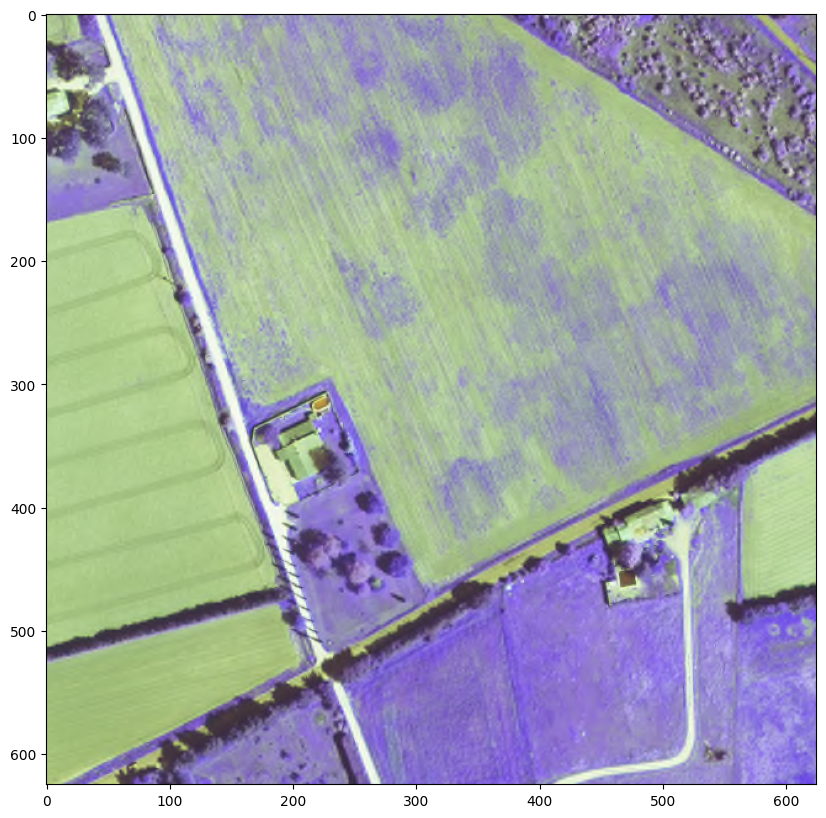

In [5]:
# Convert to HSV color space and show image
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img_bgr)
plt.show()

Filter

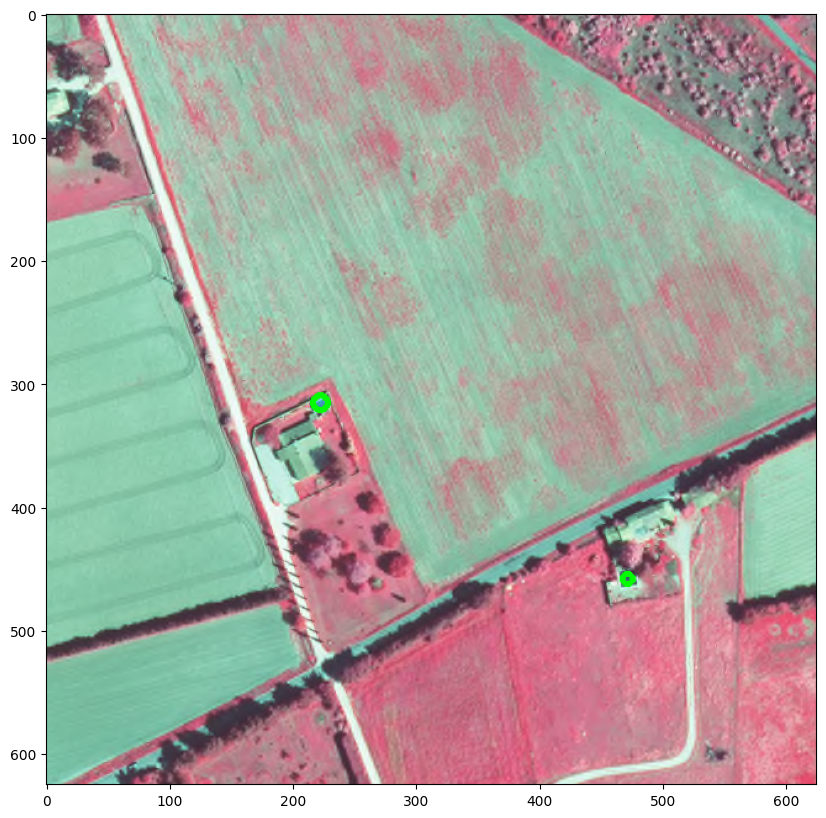

In [6]:
def detect_pools(image):
    # Convert to HSV color space for easier color filtering
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Orange color range
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([20, 255, 255])

    # Red color range (might need two parts)
    # Lower red
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    # Upper red
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for each color
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine masks
    mask = cv2.bitwise_or(mask_yellow, mask_orange)
    mask = cv2.bitwise_or(mask, mask_red1)
    mask = cv2.bitwise_or(mask, mask_red2)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter for rectangular or circular shapes
    for cnt in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

        # Check for rectangular shapes
        if len(approx) == 4:
            cv2.drawContours(image, [approx], 0, (0, 255, 0), 3)  # Green rectangle

        # Check for circular shapes
        elif len(approx) > 10:
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(image, center, radius, (0, 255, 0), 3)  # Green circle

    return image

img_copy = np.copy(img)
result = detect_pools(img_copy)
if result is not None:
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.show()

#### Let's build the algorithm

In [7]:
def detect_swimming_pools(image):
    # Convert to HSV color space for easier color filtering
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Orange color range
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([20, 255, 255])

    # Red color range (might need two parts)
    # Lower red
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    # Upper red
    lower_red2 = np.array([170, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for each color
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine masks
    mask = cv2.bitwise_or(mask_yellow, mask_orange)
    mask = cv2.bitwise_or(mask, mask_red1)
    mask = cv2.bitwise_or(mask, mask_red2)
    
    pool_centers = []
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter for rectangular or circular shapes
    for cnt in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

        # Check for rectangular or circular shapes and get center
        if len(approx) == 4 or len(approx) > 10:
            M = cv2.moments(cnt)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                pool_centers.append((cx, cy))

        elif len(approx) > 10:
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            pool_centers.append((int(x), int(y)))

    return pool_centers

In [8]:
def process_and_save_coordinates(img, nb_split, original_width, original_height):
    img_split = split_image(img, nb_split)
    all_pool_centers = []

    for i in range(nb_split):
        for j in range(nb_split):
            split_img = img_split[i * nb_split + j]
            split_pool_centers = detect_swimming_pools(split_img)

            # Adjust coordinates based on split offset
            split_x_offset = j * original_width // nb_split
            split_y_offset = i * original_height // nb_split
            adjusted_centers = [(x + split_x_offset, y + split_y_offset) for x, y in split_pool_centers]

            all_pool_centers.extend(adjusted_centers)

    return all_pool_centers

# Example usage
original_width, original_height, _ = full_img.shape
pool_centers = process_and_save_coordinates(full_img, NB_SPLIT, original_width, original_height)
print(pool_centers)

[(471, 458), (222, 315), (1207, 153), (1309, 459), (1414, 349), (1304, 210), (1253, 190), (2668, 27), (3016, 16), (3690, 311), (3638, 141), (3600, 124), (3591, 8), (4372, 494), (4331, 487), (4004, 483), (4330, 436), (4331, 410), (4323, 407), (4313, 400), (4328, 393), (4251, 226), (4312, 209), (3812, 196), (3846, 195), (3828, 191), (4082, 55), (3853, 46), (3972, 33), (3923, 38), (3772, 19), (4399, 536), (4394, 499), (4377, 492), (4491, 408), (4453, 377), (4459, 311), (4962, 255), (4954, 256), (4972, 253), (4990, 252), (4606, 136), (4400, 78), (4427, 6), (5604, 536), (5596, 509), (5242, 505), (5567, 504), (5207, 483), (5191, 482), (5232, 473), (5242, 468), (5316, 469), (5258, 446), (5606, 427), (5481, 410), (5470, 406), (5452, 406), (5510, 405), (5492, 330), (5504, 318), (5504, 313), (5115, 318), (5550, 305), (5522, 249), (5005, 248), (5013, 247), (5021, 246), (5038, 245), (5031, 245), (5046, 243), (5060, 242), (5244, 168), (5168, 136), (5151, 127), (5317, 112), (5235, 108), (5205, 107),

In [9]:
print(len(pool_centers))

916
